In [2]:
import pandas as pd
import numpy as np
import re

# 소매판매액지수

In [20]:
PATH = "data/실물지표/소매판매액지수raw.csv"

def read_csv_kor(path: str) -> pd.DataFrame:
    for enc in ("cp949", "euc-kr", "utf-8-sig", "utf-8"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    raise ValueError("CSV를 읽지 못했습니다. 인코딩/파일 손상 여부를 확인하세요.")

raw = read_csv_kor(PATH)

# 2) id 컬럼(첫 컬럼) + 날짜 컬럼 분리
id_col = raw.columns[0]  # 실제 파일에서는 '재별 및 상품군별'
date_cols = [c for c in raw.columns[1:]]

# 3) wide -> long
long = raw.melt(
    id_vars=[id_col],
    value_vars=date_cols,
    var_name="month_raw",
    value_name="value"
)

# 4) 컬럼명 정리: 'p)' 제거, 공백 제거
long["month_raw"] = long["month_raw"].astype(str).str.strip()
long["month_clean"] = long["month_raw"].str.replace(r"\s*p\)\s*$", "", regex=True).str.strip()

# 5) YYYY.M / YYYY.MM 파싱
#    예: '2025.1' 같은 케이스 존재
m = long["month_clean"].str.extract(r"^(?P<year>\d{4})\.(?P<month>\d{1,2})$")
long = pd.concat([long, m], axis=1)
long = long.dropna(subset=["year", "month"])

long["year"] = long["year"].astype(int)
long["month_str"] = long["month"].astype(str)
long["month"] = long["month"].astype(int)

# 6) 핵심 보정: '2025.1'이 '2025.10'인 케이스 처리
#    규칙: 같은 해에 이미 .01(1월)이 존재하는데 month==1이 또 나오면,
#         그 중 "원문이 한 자리(.1)"인 건 10월로 간주
#    (실제 파일에서 2025.01도 있고 2025.1도 있어서 이 보정이 꼭 필요)
def fix_month_10_if_needed(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # 원문이 한 자리 month였는지(.1 형태) 표시
    out["is_single_digit_month"] = out["month_clean"].str.match(r"^\d{4}\.\d$")

    # (year, month) 중복 탐지
    dup_mask = out.duplicated(subset=["year", "month"], keep=False)

    # 중복이면서 month==1 이고 single-digit(.1)인 것만 10월로 보정
    mask = dup_mask & (out["month"] == 1) & (out["is_single_digit_month"])
    out.loc[mask, "month"] = 10

    return out.drop(columns=["is_single_digit_month"])

long = fix_month_10_if_needed(long)

# 7) 날짜 생성 (월초로 통일)
long["date"] = pd.to_datetime(
    dict(year=long["year"], month=long["month"], day=1),
    errors="coerce"
)
long = long.dropna(subset=["date"])

# 8) 값 숫자화
long["value"] = (
    long["value"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
)
long["value"] = pd.to_numeric(long["value"], errors="coerce")

# 9) (선택) 여러 행이 있을 경우 특정 시리즈 선택 가능
#    현재 파일은 보통 '총지수' 1행이라 그대로 진행
# target = "총지수"
# long = long[long[id_col].astype(str).str.strip() == target]

# 10) 월별 시계열 정리: 중복 월은 평균
retail = (
    long[["date", "value"]]
    .dropna(subset=["value"])
    .sort_values("date")
    .groupby("date", as_index=True)["value"]
    .mean()
    .to_frame()
)

# 11) 월 빈칸 채우기 + 보간 (월별 MS)
full_idx = pd.date_range(retail.index.min(), retail.index.max(), freq="MS")
retail = retail.reindex(full_idx)
retail.index.name = "date"
retail["value"] = retail["value"].interpolate("linear")

retail = retail.loc["2004-01-01":]

retail["yoy"] = retail["value"].pct_change(12)
retail["retail_z"] = (retail["yoy"] - retail["yoy"].mean()) / retail["yoy"].std()

retail_df = retail.dropna().copy()

print("최종 기간:", retail_df.index.min().date(), "~", retail_df.index.max().date())
print(retail_df.head())
retail_df.to_csv('data/preprocessed/소매판매액지수.csv')

최종 기간: 2005-01-01 ~ 2025-12-01
            value       yoy  retail_z
date                                 
2005-01-01   60.9 -0.036392 -1.700160
2005-02-01   59.2  0.044092  0.510750
2005-03-01   63.7  0.051155  0.704783
2005-04-01   62.4  0.028007  0.068890
2005-05-01   63.7  0.032415  0.189987


In [27]:
retail_df.isna().sum()

value       0
yoy         0
retail_z    0
dtype: int64

In [28]:
retail_df["retail_z"].describe()

count    2.520000e+02
mean    -1.409807e-17
std      1.000000e+00
min     -2.840291e+00
25%     -6.236197e-01
50%     -9.230892e-02
75%      7.040227e-01
max      2.819396e+00
Name: retail_z, dtype: float64

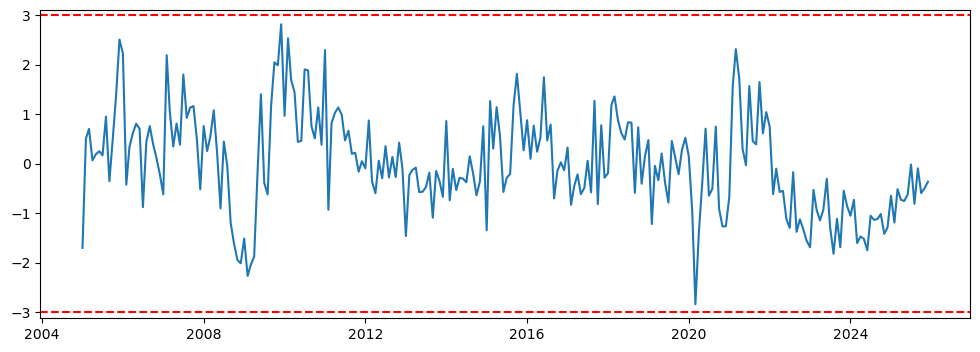

In [29]:
plt.figure(figsize=(12,4))
plt.plot(retail_df.index, retail_df["retail_z"])
plt.axhline(3, color='r', linestyle='--')
plt.axhline(-3, color='r', linestyle='--')
plt.show()


# 신용카드사용액

In [3]:
PATH = "data/실물지표/신용카드사용액raw.csv"

def read_csv_kor(path: str) -> pd.DataFrame:
    for enc in ("cp949", "euc-kr", "utf-8-sig", "utf-8"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    raise ValueError("CSV를 읽지 못했습니다. 인코딩/파일 손상 여부를 확인하세요.")

raw = read_csv_kor(PATH)

# 2) 메타 컬럼 + 날짜 컬럼 분리
meta_cols = ["통계표", "계정항목", "금융기관 유형코드", "단위", "변환"]
meta_cols = [c for c in meta_cols if c in raw.columns]
date_cols = [c for c in raw.columns if c not in meta_cols]

# 3) wide -> long
long = raw.melt(
    id_vars=meta_cols,
    value_vars=date_cols,
    var_name="month_raw",
    value_name="value"
)

# 4) Jan-03 형태의 월 파싱
MONTH_MAP = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

def parse_month_col(s: str):
    s = str(s).strip()
    m = re.match(r"^(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)-(\d{2})$", s)
    if not m:
        return (np.nan, np.nan)
    mon_str, yy = m.group(1), int(m.group(2))
    year = 2000 + yy
    month = MONTH_MAP[mon_str]
    return (year, month)

ym = long["month_raw"].apply(parse_month_col)
long["year"] = ym.apply(lambda x: x[0])
long["month"] = ym.apply(lambda x: x[1])

long = long.dropna(subset=["year", "month"])

long["year"] = long["year"].astype(int)
long["month"] = long["month"].astype(int)

# 5) 날짜 생성 (월초 기준)
long["date"] = pd.to_datetime(
    dict(year=long["year"], month=long["month"], day=1),
    errors="coerce"
)
long = long.dropna(subset=["date"])

# 6) 값 숫자화 (콤마 제거)
long["value"] = (
    long["value"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
)
long["value"] = pd.to_numeric(long["value"], errors="coerce")

# 7) (선택) 특정 시리즈 선택 가능
# target_account = "개인 이용건수"
# long = long[long["계정항목"].astype(str).str.strip() == target_account]

# 8) 월별 시계열 정리 (중복 월은 평균)
card = (
    long[["date", "value"]]
    .dropna(subset=["value"])
    .sort_values("date")
    .groupby("date", as_index=True)["value"]
    .mean()
    .to_frame()
)

# 9) 월 빈칸 채우기 + 보간 (MS 기준)
full_idx = pd.date_range(card.index.min(), card.index.max(), freq="MS")
card = card.reindex(full_idx)
card.index.name = "date"

if card["value"].isna().any():
    card["value"] = card["value"].interpolate("linear")

# 10) 분석 시작 시점 통일
card = card.loc["2004-01-01":]

# 11) YoY 및 z-score 계산
card["yoy"] = card["value"].pct_change(12)
card["card_z"] = (card["yoy"] - card["yoy"].mean()) / card["yoy"].std()

card_df = card.dropna().copy()

print("최종 기간:", card_df.index.min().date(), "~", card_df.index.max().date())
print(card_df.head())

card_df.to_csv("data/preprocessed/신용카드사용액.csv", encoding="utf-8-sig")


최종 기간: 2005-01-01 ~ 2025-11-01
               value       yoy    card_z
date                                    
2005-01-01  184994.0  0.171538  0.918533
2005-02-01  170907.0  0.127987  0.269869
2005-03-01  202525.0  0.146184  0.540902
2005-04-01  197053.0  0.143357  0.498793
2005-05-01  215317.0  0.201948  1.371486
